# Additional example on LUAD genetic screening


The data corresponds to two plates in an ORF overexpression genetic screen in A549 cells (ID: BBBC043). This dataset was used at the [CytoData Hackathon 2018](https://github.com/cytodata/cytodata-hackathon-2018).
To access the data (<25MB), you will need to use the [AWS command line client]() (no account is required). You can then run the following commands to copy the three files required:

    aws s3 cp "s3://cytodata/datasets/LUAD-BBBC043-Caicedo/profiles_cp/LUAD-BBBC043-Caicedo/52649/52649.csv" Data/ --no-sign-request
    aws s3 cp "s3://cytodata/datasets/LUAD-BBBC043-Caicedo/profiles_cp/LUAD-BBBC043-Caicedo/52653/52653.csv" Data/ --no-sign-request
    aws s3 cp "s3://cytodata/datasets/LUAD-BBBC043-Caicedo/metadata/LUAD-BBBC043-Caicedo/combined_platemaps_AHB_20150506_ssedits.csv" Data/ --no-sign-request

In [1]:
using CSV, DataFrames, UMAP, RCall, FreqTables

In [2]:
using Statistics, StatsBase, Distances, Random

In [3]:
using BioProfiling

In [4]:
using Dates: now
now()

2021-10-13T14:04:09.183

## R Calls

In [5]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel

In [6]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
ttf_import("/tmp/.fonts")
loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Registering fonts with R
└ @ RCall /opt/julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Scanning ttf files in /tmp/.fonts ...
│ Extracting .afm files from .ttf files...
│ /tmp/.fonts/Arial.ttf : ArialMT already registered in fonts database. Skipping.
│ Found FontName for 0 fonts.
│ Scanning afm files in /opt/conda/lib/R/library/extrafontdb/metrics
│ Warning in grepl("^FamilyName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FontName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FullName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^Weight", text) :
│   input string 4 is invalid in this locale
└ @ RCall /opt/julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Arial already registered with pdfFonts().
└ @ RCall /opt/julia/packages/RCall/iMDW2/src/io.jl:160


RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



In [7]:
# Larger inline plots
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 500, :height => 400))

Ptr{VecSxp} @0x000000000b967f90

## Load data
CytoData2018 LUAD dataset (see description above).

## Keeping plates separated

In [8]:
luad1 = CSV.read("Data/52653.csv", DataFrame, header = 1);
luad2 = CSV.read("Data/52649.csv", DataFrame, header = 1);
# Needed for matching well with annotations
luad1.Image_Metadata_Well = uppercase.(luad1.Image_Metadata_Well);
luad2.Image_Metadata_Well = uppercase.(luad2.Image_Metadata_Well);
luad_annotation = CSV.read("Data/combined_platemaps_AHB_20150506_ssedits.csv", DataFrame, header = 1);
# Plate(s) selected belong to the following plate group
plategroup_ind = luad_annotation.PlateName .== "DOC45.46.47.48"
luad1 = innerjoin(luad1, luad_annotation[plategroup_ind, :], on = :Image_Metadata_Well => :Well);
luad2 = innerjoin(luad2, luad_annotation[plategroup_ind, :], on = :Image_Metadata_Well => :Well);

In [9]:
# Create an Experiment object encapsulating the data
xp1 = Experiment(copy(luad1), description = "Aggregated spot measurements")
xp2 = Experiment(copy(luad2), description = "Aggregated spot measurements")

"Experiment with 384/384 entries and 1798/1798 features selected."

In [10]:
# We want to focus on the genes targetted the most often
symbolfreq = freqtable(vcat(luad1.Symbol, luad2.Symbol))
keptsymbol = collect(skipmissing(names(symbolfreq[symbolfreq .>= 8])...))

28-element Array{String15,1}:
 "ABCB9"
 "ARAF"
 "BFP"
 "CTNNB1"
 "DCAF8"
 "EGFR"
 "FCGR3B"
 "HAVCR2"
 "HcRed"
 "KEAP1"
 "KRAS"
 "LUCIFERASE"
 "MAX"
 ⋮
 "PIK3R3"
 "RARA"
 "RBM10"
 "RBM45"
 "RIT1"
 "SERPINB5"
 "STC2"
 "STK11"
 "TP53"
 "TPK1"
 "ZBTB24"
 "eGFP"

## Separate analyses

In [11]:
Random.seed!(3895);

In [12]:
ctrl_symbols = ["eGFP", "LUCIFERASE", "HcRed", "BFP"]
strg_symbols = ["CTNNB1", "KRAS"]

2-element Array{String,1}:
 "CTNNB1"
 "KRAS"

### Plate 1

In [13]:
# Remove position information
strToRemove = ["Orientation", "_X", "_Y", "Metadata", names(luad_annotation)...]
filters = Array{BioProfiling.AbstractReduce,1}([
        NameSelector(x -> !any(occursin.(strToRemove, String(x)))) ])  

1-element Array{BioProfiling.AbstractReduce,1}:
 NameSelector(var"#1#2"(), "No description provided")

In [14]:
push!(filters, MissingFilter(:Symbol));

In [15]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y)) 
# We now only keep hit compounds
push!(filters, Filter(keptsymbol, :Symbol, compare = compare_in));

In [16]:
select!(xp1, filters);

In [17]:
logtransform!(xp1);

In [18]:
ctrl_filter = Filter("ctl_vector", :pert_type, description = "Get control wells")

Filter("ctl_vector", :pert_type, isequal, "Get control wells")

Could be investigates further: this leads to really uninformative UMAPs:
`normtransform!(xp1, ctrl_filter);`

In [19]:
select_features!(xp1,
                 Selector(x -> !any(isnan.(x)), 
                        description = "Remove features with infinite values " *
                            "(i.e. with no variation for a subset of the control wells)"));

In [20]:
decorrelate_by_mad!(xp1);

In [21]:
stime = now()
uxp1 = umap(xp1, spread = 10)
print(now() - stime)

28709 milliseconds

In [22]:
uxp1 = convert(DataFrame, uxp1')
rename!(uxp1, [:UMAP1, :UMAP2]);

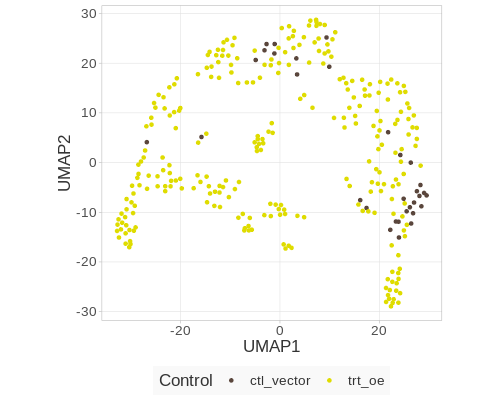

RObject{VecSxp}


In [23]:
uxp1.Control = xp1.data[xp1.selected_entries, :pert_type];
ggplot(uxp1, aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Control)) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
#     guides(color = false) +
    RObject(nothing)

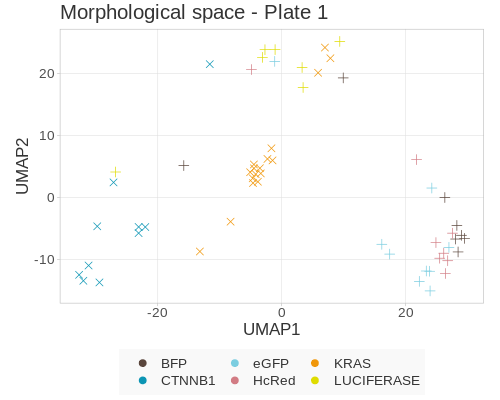

RObject{VecSxp}


In [24]:
uxp1.Symbol = xp1.data[xp1.selected_entries, :Symbol];
selected_genes = [strg_symbols..., ctrl_symbols...]
selected_genes_ind = [ismissing(x) ? false : x in selected_genes for x in uxp1.Symbol]
freqtable(uxp1[selected_genes_ind, :Symbol])
gp1 = ggplot(uxp1[selected_genes_ind,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Symbol, shape = :Control), size = 3) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    scale_shape_manual(name = "",
                       labels = ["ctrl_vector", "trt_oe"],
                       values = [3, 4]) +
    ggtitle("Morphological space - Plate 1") +
    guides(shape = false, color = guide_legend(title="")) +
    RObject(nothing)

In [25]:
ggsave("fig/S2_1.pdf", height = 6, width = 12, gp1)

RObject{NilSxp}
NULL


### Plate 2

In [26]:
# Remove position information
strToRemove = ["Orientation", "_X", "_Y", "Metadata", names(luad_annotation)...]
filters = Array{BioProfiling.AbstractReduce,1}([
        NameSelector(x -> !any(occursin.(strToRemove, String(x)))) ])  

1-element Array{BioProfiling.AbstractReduce,1}:
 NameSelector(var"#7#8"(), "No description provided")

In [27]:
push!(filters, MissingFilter(:Symbol));

In [28]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y)) 
# We now only keep hit compounds
push!(filters, Filter(keptsymbol, :Symbol, compare = compare_in));

In [29]:
select!(xp2, filters);

In [30]:
logtransform!(xp2);

In [31]:
ctrl_filter = Filter("ctl_vector", :pert_type, description = "Get control wells")

Filter("ctl_vector", :pert_type, isequal, "Get control wells")

In [32]:
select_features!(xp2,
                 Selector(x -> !any(isnan.(x)), 
                        description = "Remove features with infinite values " *
                            "(i.e. with no variation for a subset of the control wells)"));

In [33]:
decorrelate_by_mad!(xp2);

In [34]:
stime = now()
uxp2 = umap(xp2, spread = 10)
print(now() - stime)

459 milliseconds

In [35]:
uxp2 = convert(DataFrame, uxp2')
rename!(uxp2, [:UMAP1, :UMAP2]);

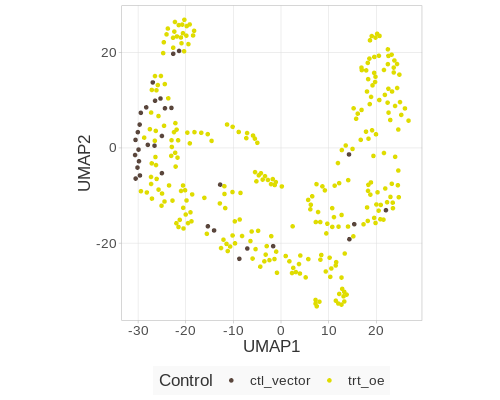

RObject{VecSxp}


In [36]:
uxp2.Control = xp2.data[xp2.selected_entries, :pert_type];
ggplot(uxp2, aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Control)) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
#     guides(color = false) +
    RObject(nothing)

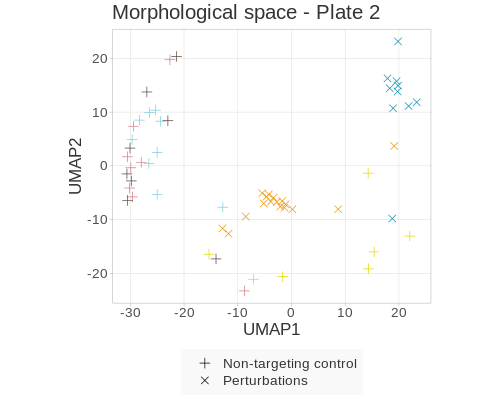

RObject{VecSxp}


In [37]:
uxp2.Symbol = xp2.data[xp2.selected_entries, :Symbol];
selected_genes = [strg_symbols..., ctrl_symbols...]
selected_genes_ind = [ismissing(x) ? false : x in selected_genes for x in uxp2.Symbol]
freqtable(uxp2[selected_genes_ind, :Symbol])
gp2 = ggplot(uxp2[selected_genes_ind,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Symbol, shape = :Control), size = 3) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    scale_shape_manual(name = "",
                       labels = ["Non-targeting control", "Perturbations"],
                       values = [3, 4]) +
    ggtitle("Morphological space - Plate 2") +
    guides(color = false, shape = guide_legend(nrow=2,byrow=true)) +
    RObject(nothing)

In [38]:
ggsave("fig/S2_2.pdf", height = 6, width = 12, gp2)

RObject{NilSxp}
NULL


## Do distances to control wells correlate?

In [39]:
Random.seed!(3895);

In [40]:
xp1_umap = Experiment(uxp1)
xp2_umap = Experiment(uxp2)
xp1_umap.selected_features = xp2_umap.selected_features = [1,2];

In [41]:
xp1_gene = xp1.data[xp1.selected_entries, :Symbol]
xp2_gene = xp2.data[xp2.selected_entries, :Symbol]
xp1_ctrl = xp1.data[xp1.selected_entries, :pert_type] .== "ctl_vector"
xp2_ctrl = xp2.data[xp2.selected_entries, :pert_type] .== "ctl_vector"
@assert xp1_gene == xp2_gene

In [42]:
xp_distances = DataFrame([(x, "Control") for x in levels(xp1_gene)])
rename!(xp_distances, [:A, :B]);

In [43]:
xp_distances.distance1 = [distance_robust_hellinger(getdata(xp1_umap), 
                                                         xp1_gene.==x, 
                                                         xp1_ctrl) 
                                           for x in xp_distances[:,1]];

In [44]:
xp_distances.distance2 = [distance_robust_hellinger(getdata(xp2_umap), 
                                                         xp2_gene.==x, 
                                                         xp2_ctrl) 
                                           for x in xp_distances[:,1]];

In [45]:
xp_distances

,A,B,distance1,distance2
,String15,String,Float64,Float64
1,ABCB9,Control,1.0,1.0
2,ARAF,Control,0.754547,0.83044
3,BFP,Control,0.377804,0.242321
4,CTNNB1,Control,1.0,1.0
5,DCAF8,Control,0.590784,0.317704
6,EGFR,Control,0.981347,0.999082
7,FCGR3B,Control,1.0,0.99997
8,HAVCR2,Control,1.0,1.0
9,HcRed,Control,0.384003,0.243498


In [46]:
xp_distances.category = [x in ctrl_symbols ? "Negative controls" : 
                         x in strg_symbols ? "Most active perturbations" : "Other perturbations" 
                         for x in xp_distances.A];
xp_distances.label = [x.category == "Other perturbations" ? "" : x.A
                         for x in eachrow(xp_distances)];

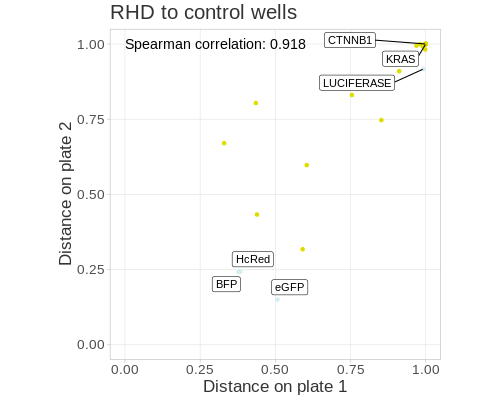

RObject{VecSxp}


In [47]:
scor = corspearman(xp_distances.distance1, xp_distances.distance2)
gp3 = ggplot(xp_distances, aes(x = :distance1, y = :distance2)) + 
    geom_point(aes(color = :category)) +
    annotate("text", label = "Spearman correlation: "*string(round(scor, digits = 3)), 
             x = 0.3, y = 1, size = 5) +
    xlab("Distance on plate 1") +
    ylab("Distance on plate 2") +
    ggtitle("RHD to control wells") +
    guides(color=false)+
    geom_label_repel(aes(label = :label), force = 1, var"max.overlaps" = 20)+
    coord_fixed() + 
    xlim(0,1) +
    ylim(0,1) +
    RObject(nothing)

In [48]:
ggsave("fig/S2_3.pdf", height = 6, width = 7, gp3)

RObject{NilSxp}
NULL


In [49]:
now()

2021-10-13T14:06:30.892